In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import os.path as path
import itertools
import scipy.io as sio
from sklearn.preprocessing import maxabs_scale

In [2]:
import tensorflow.keras as keras
from tensorflow.keras.layers import Input,InputLayer, Dense, Activation, BatchNormalization, Flatten, Conv1D
from tensorflow.keras.layers import MaxPooling1D, Dropout
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,LearningRateScheduler, EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical

In [3]:
# import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [4]:
base_dir = path.join('..', 'data')
data_dir = path.join(base_dir, 'data_speech_commands_v0.02')
 
train_txt = path.join(data_dir, 'wav_train_16words.txt')
val_txt = path.join(data_dir, 'wav_validation_16words.txt')
test_txt = path.join(data_dir, 'wav_test_16words.txt')

train_data = np.load(path.join(data_dir, 'wav_train_data.npz'))
val_data = np.load(path.join(data_dir, 'wav_validation_data.npz'))
test_data = np.load(path.join(data_dir, 'wav_test_data.npz'))

In [5]:
x_train = train_data['x_train']
y_train = train_data['y_train']
x_val = val_data['x_val']
y_val = val_data['y_val']
x_test = test_data['x_test']
y_test = test_data['y_test']
y_table = test_data['table']

In [6]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape, x_test.shape, y_test.shape, y_table.shape

((36805, 16000, 1),
 (36805,),
 (4293, 16000, 1),
 (4293,),
 (4815, 16000, 1),
 (4815,),
 (16, 2))

In [7]:
input_shape = x_test[0].shape
output_size = y_table.shape[0]

In [8]:
x_train_abs = np.asarray([maxabs_scale(wav) for wav in x_train])
y_train_onehot = np.asarray([to_categorical(label, output_size) for label in y_train])
del x_train, y_train

x_val_abs = np.asarray([maxabs_scale(wav) for wav in x_val])
y_val_onehot = np.asarray([to_categorical(label, output_size) for label in y_val])
del x_val, y_val

x_test_abs = np.asarray([maxabs_scale(wav) for wav in x_test])
y_test_onehot = np.asarray([to_categorical(label, output_size) for label in y_test])
del x_test, y_test

In [9]:
def preprocess(wav):
    wav = sklearn.preprocessing.maxabs_scale(wav)
    wav_mfcc = librosa.feature.mfcc(y=wav, n_mfcc=13)
    wav_mfcc_std = StandardScaler().fit_transform(wav_mfcc)
    wav_mfcc_std_mean = wav_mfcc_std.mean(axis=1)

    features = np.concatenate([wav_mfcc_std_mean])
    return features

In [10]:
def build_batchnorm_cnn_no_do(conv_num=1, fcn_num=1):
    model=Sequential()
    model.add(Conv1D(kernel_size=25, filters=8, strides=1, padding='valid', input_shape=input_shape))  
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling1D(pool_size=4, strides=4, padding='same'))
    
    for i in range(conv_num-1):
        model.add(Conv1D (kernel_size=25, filters=8*(2**(i+1)), strides=1, padding='valid'))  
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(MaxPooling1D(pool_size=4, strides=4, padding='same'))

    model.add(Flatten())
    
    for i in range(fcn_num):
        model.add(Dense(1024/(2**i)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        
    model.add(Dense(output_size, activation='softmax' ))
    return model

In [11]:
# model = build_cnn(conv_num=3, fcn_num=1)
# model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Train on 36805 samples, validate on 4293 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 2.0020 - acc: 0.4273
Epoch 00001: val_loss improved from inf to 1.39069, saving model to model/checkpoint/1D_CNN_BN_NO_DO_1_conv_1_fcn_checkpoint/01-1.3907.hdf5
36805/36805 [==============================] - 17s 473us/sample - loss: 2.0021 - acc: 0.4273 - val_loss: 1.3907 - val_acc: 0.6063
Epoch 2/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.7323 - acc: 0.7753
Epoch 00002: val_loss improved from 1.39069 to 1.19332, saving model to model/checkpoint/1D_CNN_BN_NO_DO_1_conv_1_fcn_checkpoint/02-1.1933.hdf5
36805/36805 [==============================] - 17s 452us/sample - loss: 0.7328 - acc: 0.7751 - val_loss: 1.1933 - val_acc: 0.6506
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.3013 - acc: 0.9155

36800/36805 [============================>.] - ETA: 0s - loss: 0.0289 - acc: 0.9946
Epoch 00027: val_loss did not improve from 1.17393
36805/36805 [==============================] - 16s 441us/sample - loss: 0.0289 - acc: 0.9946 - val_loss: 1.9207 - val_acc: 0.7202
Epoch 28/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0291 - acc: 0.9930
Epoch 00028: val_loss did not improve from 1.17393
36805/36805 [==============================] - 16s 437us/sample - loss: 0.0291 - acc: 0.9930 - val_loss: 2.1057 - val_acc: 0.7004
Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0200 - acc: 0.9960
Epoch 00029: val_loss did not improve from 1.17393
36805/36805 [==============================] - 16s 435us/sample - loss: 0.0200 - acc: 0.9960 - val_loss: 1.9911 - val_acc: 0.7200
Epoch 30/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0276 - acc: 0.9949
Epoch 00030: val_loss did not improve from 1.17393
36805/36805 [==================

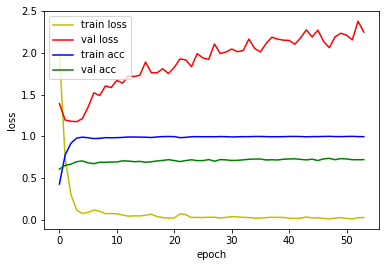

4815/4815 [==============================] - 1s 224us/sample - loss: 1.3727 - acc: 0.6474
Loss: 1.3727390080349964 Accuracy: 0.64735204

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.8700 - acc: 0.4193
Epoch 00001: val_loss improved from inf to 1.34583, saving model to model/checkpoint/1D_CNN_BN_NO_DO_1_conv_2_fcn_checkpoint/01-1.3458.hdf5
36805/36805 [==============================] - 18s 495us/sample - loss: 1.8700 - acc: 0.4194 - val_loss: 1.3458 - val_acc: 0.5931
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.7764 - acc: 0.7542
Epoch 00002: val_loss improved from 1.34583 to 1.11626, saving model to model/checkpoint/1D_CNN_BN_NO_DO_1_conv_2_fcn_checkpoint/02-1.1163.hdf5
36805/36805 [==============================] - 17s 464us/sample - loss: 0.7764 - acc: 0.7542 - val_loss: 1.1163 - val_acc: 0.6513
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.3

Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0239 - acc: 0.9949
Epoch 00029: val_loss did not improve from 1.08295
36805/36805 [==============================] - 16s 445us/sample - loss: 0.0239 - acc: 0.9949 - val_loss: 1.7871 - val_acc: 0.7326
Epoch 30/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0289 - acc: 0.9933
Epoch 00030: val_loss did not improve from 1.08295
36805/36805 [==============================] - 17s 449us/sample - loss: 0.0289 - acc: 0.9933 - val_loss: 1.8775 - val_acc: 0.7212
Epoch 31/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0365 - acc: 0.9910
Epoch 00031: val_loss did not improve from 1.08295
36805/36805 [==============================] - 17s 452us/sample - loss: 0.0365 - acc: 0.9910 - val_loss: 1.8840 - val_acc: 0.7237
Epoch 32/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0406 - acc: 0.9908
Epoch 00032: val_loss did not improve from 1.08295
36805/36805 [=====

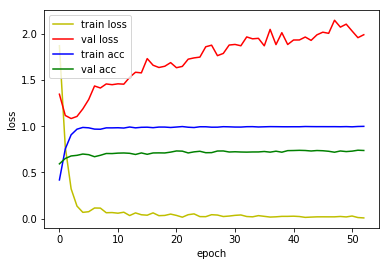

4815/4815 [==============================] - 1s 218us/sample - loss: 1.2685 - acc: 0.6314
Loss: 1.2685202360895935 Accuracy: 0.63136035

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36736/36805 [============================>.] - ETA: 0s - loss: 1.6324 - acc: 0.5324
Epoch 00001: val_loss improved from inf to 1.46466, saving model to model/checkpoint/1D_CNN_BN_NO_DO_2_conv_1_fcn_checkpoint/01-1.4647.hdf5
36805/36805 [==============================] - 18s 477us/sample - loss: 1.6319 - acc: 0.5327 - val_loss: 1.4647 - val_acc: 0.5530
Epoch 2/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.4939 - acc: 0.8488
Epoch 00002: val_loss improved from 1.46466 to 0.78094, saving model to model/checkpoint/1D_CNN_BN_NO_DO_2_conv_1_fcn_checkpoint/02-0.7809.hdf5
36805/36805 [==============================] - 15s 421us/sample - loss: 0.4936 - acc: 0.8489 - val_loss: 0.7809 - val_acc: 0.7619
Epoch 3/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.1

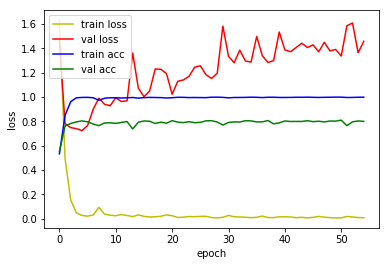

4815/4815 [==============================] - 1s 277us/sample - loss: 0.8731 - acc: 0.7659
Loss: 0.8730633901782249 Accuracy: 0.7659398

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36672/36805 [============================>.] - ETA: 0s - loss: 1.4547 - acc: 0.5462
Epoch 00001: val_loss improved from inf to 2.31198, saving model to model/checkpoint/1D_CNN_BN_NO_DO_2_conv_2_fcn_checkpoint/01-2.3120.hdf5
36805/36805 [==============================] - 19s 506us/sample - loss: 1.4535 - acc: 0.5466 - val_loss: 2.3120 - val_acc: 0.4184
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.4447 - acc: 0.8643
Epoch 00002: val_loss improved from 2.31198 to 0.77781, saving model to model/checkpoint/1D_CNN_BN_NO_DO_2_conv_2_fcn_checkpoint/02-0.7778.hdf5
36805/36805 [==============================] - 16s 445us/sample - loss: 0.4447 - acc: 0.8643 - val_loss: 0.7778 - val_acc: 0.7538
Epoch 3/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.12

Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0165 - acc: 0.9960
Epoch 00029: val_loss did not improve from 0.72378
36805/36805 [==============================] - 16s 426us/sample - loss: 0.0165 - acc: 0.9960 - val_loss: 1.3573 - val_acc: 0.7955
Epoch 30/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0208 - acc: 0.9952
Epoch 00030: val_loss did not improve from 0.72378
36805/36805 [==============================] - 16s 426us/sample - loss: 0.0208 - acc: 0.9952 - val_loss: 1.2674 - val_acc: 0.7978
Epoch 31/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0096 - acc: 0.9976
Epoch 00031: val_loss did not improve from 0.72378
36805/36805 [==============================] - 15s 407us/sample - loss: 0.0096 - acc: 0.9976 - val_loss: 1.3257 - val_acc: 0.7980
Epoch 32/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0147 - acc: 0.9966
Epoch 00032: val_loss did not improve from 0.72378
36805/36805 [=====

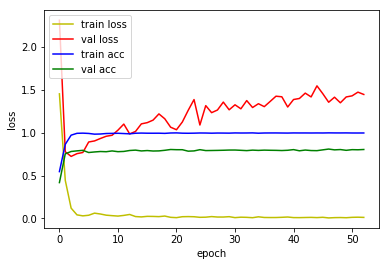

4815/4815 [==============================] - 2s 335us/sample - loss: 0.8747 - acc: 0.7408
Loss: 0.8746522920030176 Accuracy: 0.74081

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36672/36805 [============================>.] - ETA: 0s - loss: 1.3888 - acc: 0.5867
Epoch 00001: val_loss improved from inf to 1.44888, saving model to model/checkpoint/1D_CNN_BN_NO_DO_3_conv_1_fcn_checkpoint/01-1.4489.hdf5
36805/36805 [==============================] - 19s 509us/sample - loss: 1.3866 - acc: 0.5873 - val_loss: 1.4489 - val_acc: 0.5733
Epoch 2/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.5629 - acc: 0.8211
Epoch 00002: val_loss improved from 1.44888 to 0.61333, saving model to model/checkpoint/1D_CNN_BN_NO_DO_3_conv_1_fcn_checkpoint/02-0.6133.hdf5
36805/36805 [==============================] - 15s 398us/sample - loss: 0.5630 - acc: 0.8211 - val_loss: 0.6133 - val_acc: 0.8015
Epoch 3/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.3135

Epoch 28/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0131 - acc: 0.9967
Epoch 00028: val_loss did not improve from 0.51703
36805/36805 [==============================] - 14s 393us/sample - loss: 0.0131 - acc: 0.9967 - val_loss: 0.7899 - val_acc: 0.8495
Epoch 29/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0101 - acc: 0.9969
Epoch 00029: val_loss did not improve from 0.51703
36805/36805 [==============================] - 14s 392us/sample - loss: 0.0102 - acc: 0.9969 - val_loss: 0.8181 - val_acc: 0.8553
Epoch 30/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0131 - acc: 0.9965
Epoch 00030: val_loss did not improve from 0.51703
36805/36805 [==============================] - 15s 397us/sample - loss: 0.0131 - acc: 0.9965 - val_loss: 0.8173 - val_acc: 0.8521
Epoch 31/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0079 - acc: 0.9978
Epoch 00031: val_loss did not improve from 0.51703
36805/36805 [=====

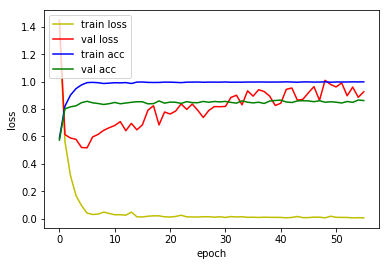

4815/4815 [==============================] - 1s 303us/sample - loss: 0.6196 - acc: 0.8297
Loss: 0.6196394032035661 Accuracy: 0.82969886

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36672/36805 [============================>.] - ETA: 0s - loss: 1.3069 - acc: 0.5871
Epoch 00001: val_loss improved from inf to 1.44199, saving model to model/checkpoint/1D_CNN_BN_NO_DO_3_conv_2_fcn_checkpoint/01-1.4420.hdf5
36805/36805 [==============================] - 21s 562us/sample - loss: 1.3050 - acc: 0.5876 - val_loss: 1.4420 - val_acc: 0.5402
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.5396 - acc: 0.8270
Epoch 00002: val_loss improved from 1.44199 to 0.57006, saving model to model/checkpoint/1D_CNN_BN_NO_DO_3_conv_2_fcn_checkpoint/02-0.5701.hdf5
36805/36805 [==============================] - 15s 415us/sample - loss: 0.5396 - acc: 0.8270 - val_loss: 0.5701 - val_acc: 0.8113
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.2

Epoch 29/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0197 - acc: 0.9941
Epoch 00029: val_loss did not improve from 0.50625
36805/36805 [==============================] - 15s 404us/sample - loss: 0.0197 - acc: 0.9941 - val_loss: 0.8550 - val_acc: 0.8532
Epoch 30/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0058 - acc: 0.9984
Epoch 00030: val_loss did not improve from 0.50625
36805/36805 [==============================] - 15s 410us/sample - loss: 0.0058 - acc: 0.9984 - val_loss: 0.7854 - val_acc: 0.8574
Epoch 31/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0143 - acc: 0.9957
Epoch 00031: val_loss did not improve from 0.50625
36805/36805 [==============================] - 15s 418us/sample - loss: 0.0143 - acc: 0.9957 - val_loss: 0.9432 - val_acc: 0.8383
Epoch 32/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0132 - acc: 0.9961
Epoch 00032: val_loss did not improve from 0.50625
36805/36805 [=====

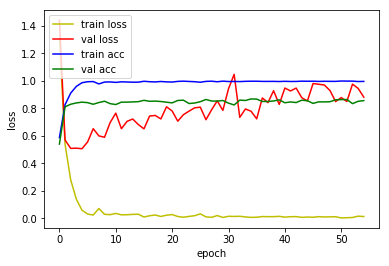

4815/4815 [==============================] - 2s 356us/sample - loss: 0.6588 - acc: 0.8143
Loss: 0.6588104744442774 Accuracy: 0.8143302

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.3057 - acc: 0.5974
Epoch 00001: val_loss improved from inf to 1.21769, saving model to model/checkpoint/1D_CNN_BN_NO_DO_4_conv_1_fcn_checkpoint/01-1.2177.hdf5
36805/36805 [==============================] - 22s 604us/sample - loss: 1.3055 - acc: 0.5975 - val_loss: 1.2177 - val_acc: 0.6061
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.5400 - acc: 0.8270
Epoch 00002: val_loss improved from 1.21769 to 0.46173, saving model to model/checkpoint/1D_CNN_BN_NO_DO_4_conv_1_fcn_checkpoint/02-0.4617.hdf5
36805/36805 [==============================] - 15s 398us/sample - loss: 0.5400 - acc: 0.8270 - val_loss: 0.4617 - val_acc: 0.8519
Epoch 3/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.33

Epoch 28/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0064 - acc: 0.9982
Epoch 00028: val_loss did not improve from 0.35249
36805/36805 [==============================] - 15s 397us/sample - loss: 0.0064 - acc: 0.9982 - val_loss: 0.4968 - val_acc: 0.8984
Epoch 29/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0132 - acc: 0.9961
Epoch 00029: val_loss did not improve from 0.35249
36805/36805 [==============================] - 15s 395us/sample - loss: 0.0132 - acc: 0.9961 - val_loss: 0.4744 - val_acc: 0.9040
Epoch 30/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0059 - acc: 0.9983
Epoch 00030: val_loss did not improve from 0.35249
36805/36805 [==============================] - 14s 392us/sample - loss: 0.0060 - acc: 0.9983 - val_loss: 0.5391 - val_acc: 0.8926
Epoch 31/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0148 - acc: 0.9958
Epoch 00031: val_loss did not improve from 0.35249
36805/36805 [=====


4 Conv 1 FCN BN NO_DO Model


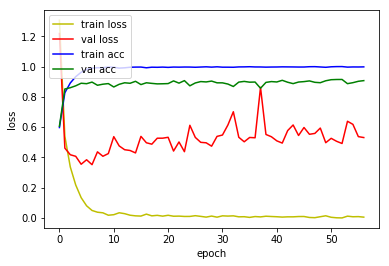

4815/4815 [==============================] - 2s 333us/sample - loss: 0.4835 - acc: 0.8602
Loss: 0.4834551486394611 Accuracy: 0.8602285

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36672/36805 [============================>.] - ETA: 0s - loss: 1.2895 - acc: 0.5877
Epoch 00001: val_loss improved from inf to 1.35708, saving model to model/checkpoint/1D_CNN_BN_NO_DO_4_conv_2_fcn_checkpoint/01-1.3571.hdf5
36805/36805 [==============================] - 24s 650us/sample - loss: 1.2867 - acc: 0.5886 - val_loss: 1.3571 - val_acc: 0.5535
Epoch 2/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.5782 - acc: 0.8120
Epoch 00002: val_loss improved from 1.35708 to 0.48150, saving model to model/checkpoint/1D_CNN_BN_NO_DO_4_conv_2_fcn_checkpoint/02-0.4815.hdf5
36805/36805 [==============================] - 16s 431us/sample - loss: 0.5778 - acc: 0.8120 - val_loss: 0.4815 - val_acc: 0.8409
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.35

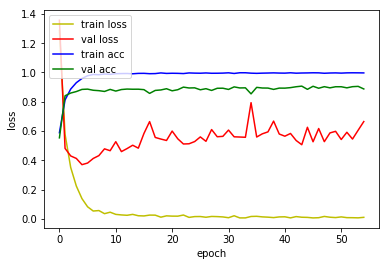

4815/4815 [==============================] - 2s 325us/sample - loss: 0.4920 - acc: 0.8498
Loss: 0.4920445267532721 Accuracy: 0.8498442

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.3342 - acc: 0.5768
Epoch 00001: val_loss improved from inf to 1.69505, saving model to model/checkpoint/1D_CNN_BN_NO_DO_5_conv_1_fcn_checkpoint/01-1.6951.hdf5
36805/36805 [==============================] - 27s 738us/sample - loss: 1.3342 - acc: 0.5767 - val_loss: 1.6951 - val_acc: 0.4731
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.6300 - acc: 0.7982
Epoch 00002: val_loss improved from 1.69505 to 0.55999, saving model to model/checkpoint/1D_CNN_BN_NO_DO_5_conv_1_fcn_checkpoint/02-0.5600.hdf5
36805/36805 [==============================] - 16s 422us/sample - loss: 0.6300 - acc: 0.7982 - val_loss: 0.5600 - val_acc: 0.8237
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.42

Epoch 28/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0165 - acc: 0.9951
Epoch 00028: val_loss did not improve from 0.29036
36805/36805 [==============================] - 15s 415us/sample - loss: 0.0164 - acc: 0.9951 - val_loss: 0.3852 - val_acc: 0.9171
Epoch 29/200
36736/36805 [============================>.] - ETA: 0s - loss: 0.0175 - acc: 0.9947
Epoch 00029: val_loss did not improve from 0.29036
36805/36805 [==============================] - 15s 416us/sample - loss: 0.0176 - acc: 0.9947 - val_loss: 0.4559 - val_acc: 0.8998
Epoch 30/200
36672/36805 [============================>.] - ETA: 0s - loss: 0.0243 - acc: 0.9917
Epoch 00030: val_loss did not improve from 0.29036
36805/36805 [==============================] - 15s 414us/sample - loss: 0.0243 - acc: 0.9917 - val_loss: 0.3666 - val_acc: 0.9192
Epoch 31/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.0210 - acc: 0.9933
Epoch 00031: val_loss did not improve from 0.29036
36805/36805 [=====


5 Conv 1 FCN BN NO_DO Model


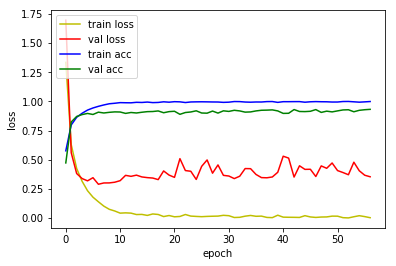

4815/4815 [==============================] - 2s 331us/sample - loss: 0.4023 - acc: 0.8779
Loss: 0.40226624905753605 Accuracy: 0.87788165

Train on 36805 samples, validate on 4293 samples
Epoch 1/200
36800/36805 [============================>.] - ETA: 0s - loss: 1.2627 - acc: 0.5995
Epoch 00001: val_loss improved from inf to 1.07892, saving model to model/checkpoint/1D_CNN_BN_NO_DO_5_conv_2_fcn_checkpoint/01-1.0789.hdf5
36805/36805 [==============================] - 29s 794us/sample - loss: 1.2626 - acc: 0.5996 - val_loss: 1.0789 - val_acc: 0.6427
Epoch 2/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.5458 - acc: 0.8234
Epoch 00002: val_loss improved from 1.07892 to 0.42122, saving model to model/checkpoint/1D_CNN_BN_NO_DO_5_conv_2_fcn_checkpoint/02-0.4212.hdf5
36805/36805 [==============================] - 16s 433us/sample - loss: 0.5457 - acc: 0.8234 - val_loss: 0.4212 - val_acc: 0.8686
Epoch 3/200
36800/36805 [============================>.] - ETA: 0s - loss: 0.

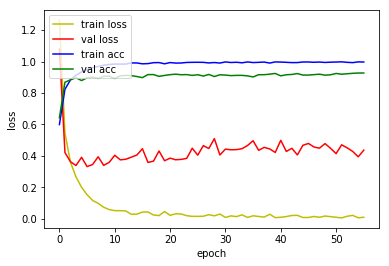

4815/4815 [==============================] - 2s 387us/sample - loss: 0.4297 - acc: 0.8710
Loss: 0.4297190947200898 Accuracy: 0.87102807



In [12]:
for i in range(1, 6):
    for j in range(1, 3):
        model = build_batchnorm_cnn_no_do(conv_num=i, fcn_num=j)
#         model.summary()
        model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=1e-4),
              metrics=['accuracy'])
    
        model_path = 'model/checkpoint/1D_CNN_BN_NO_DO_{}_conv_{}_fcn_checkpoint/'.format(i, j)
        os.makedirs(model_path, exist_ok=True)
        model_filename = model_path+'{epoch:02d}-{val_loss:.4f}.hdf5'
        checkpointer = ModelCheckpoint(filepath = model_filename, monitor = "val_loss", 
                                       verbose=1, save_best_only=True)

        early_stopping = EarlyStopping(monitor='val_loss', patience=50)
        hist = model.fit(x_train_abs, y_train_onehot, batch_size=64, epochs=200, 
                         validation_data=[x_val_abs, y_val_onehot], shuffle=True, 
                         callbacks = [checkpointer, early_stopping])
        print()
        print('{} Conv {} FCN BN NO_DO Model'.format(i, j))
        fig, ax = plt.subplots()
        ax.plot(hist.history['loss'], 'y', label='train loss')
        ax.plot(hist.history['val_loss'], 'r', label='val loss')
        ax.plot(hist.history['acc'], 'b', label='train acc')
        ax.plot(hist.history['val_acc'], 'g', label='val acc')
        ax.set_xlabel('epoch')
        ax.set_ylabel('loss')
        ax.legend(loc='upper left')
        plt.show()

        png_path = 'visualization/learning_curve/'
        filename = '1D_BN_CNN_NO_DO_{}_conv_{}_fcn'.format(i, j)+'.png'
        os.makedirs(png_path, exist_ok=True)
        fig.savefig(png_path+filename, transparent=True)

        del(model)
        
        model_path = 'model/checkpoint/1D_CNN_BN_NO_DO_{}_conv_{}_fcn_checkpoint/'.format(i, j)
        model_filename = model_path + sorted(os.listdir(model_path))[-1]
        model = load_model(model_filename)
        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)
        print()
        
        del(model)

In [13]:
for i in range(1, 6):
    for j in range(1, 3):
        print()
        print('{} Conv {} FCN Model'.format(i, j))
#         model = build_cnn(conv_num=i, fcn_num=j)
        model_path = 'model/checkpoint/1D_CNN_BN_NO_DO_{}_conv_{}_fcn_checkpoint/'.format(i, j)
        model_filename = model_path + sorted(os.listdir(model_path))[-1]
#         model_filename = model_path + '{epoch:02d}-{val_loss:.4f}.hdf5'
  
        model = load_model(model_filename)
        model.summary()
    
        [loss, accuracy] = model.evaluate(x_test_abs, y_test_onehot)
        print('Loss:', loss, 'Accuracy:', accuracy)
        
        del(model)


1 Conv 1 FCN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 15976, 8)          208       
_________________________________________________________________
batch_normalization_v1 (Batc (None, 15976, 8)          32        
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 3994, 8)           0         
_________________________________________________________________
flatten (Flatten)            (None, 31952)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              32719872  
_________________________________________________________________
dense_1 (Dense)              (None, 16)                16400     
Total params: 32,736,512
Trainable params: 32,736,496
Non-trainable params: 16
___________________________________________

4815/4815 [==============================] - 3s 520us/sample - loss: 0.4023 - acc: 0.8779
Loss: 0.40226624905753605 Accuracy: 0.87788165

5 Conv 2 FCN Model
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_25 (Conv1D)           (None, 15976, 8)          208       
_________________________________________________________________
batch_normalization_v1_25 (B (None, 15976, 8)          32        
_________________________________________________________________
max_pooling1d_25 (MaxPooling (None, 3994, 8)           0         
_________________________________________________________________
conv1d_26 (Conv1D)           (None, 3970, 16)          3216      
_________________________________________________________________
batch_normalization_v1_26 (B (None, 3970, 16)          64        
_________________________________________________________________
max_pooling1d_26 (MaxPooling (None, 993, 16)       